In [1]:
import geopandas as gpd
import pandas as pd


In [2]:
shapefile_path = "UScounties.shp"
# gdf = gpd.read_file(shapefile_path)
# print(gdf.head())
# gdf.plot()

In [3]:
# pd.read_csv("covidData2021-2022.csv", dtype={'date': pd.StringDtype(), 'county': pd.StringDtype(), 'state': pd.StringDtype(), 'fips': pd.StringDtype(), 'cases': pd.Int64Dtype(), 'deaths': pd.Int64Dtype()},keep_default_na=False,na_values=pd.NA)
covid_data=pd.read_csv("covidData2021-2022.csv")


covid_data["date"] = pd.to_datetime(covid_data["date"])
print(covid_data.head(-20))
print(covid_data.info())

              date     county       state     fips  cases  deaths
0       2020-01-21  Snohomish  Washington  53061.0      1     0.0
1       2020-01-22  Snohomish  Washington  53061.0      1     0.0
2       2020-01-23  Snohomish  Washington  53061.0      1     0.0
3       2020-01-24       Cook    Illinois  17031.0      1     0.0
4       2020-01-24  Snohomish  Washington  53061.0      1     0.0
...            ...        ...         ...      ...    ...     ...
2502807 2022-05-13  Winnebago   Wisconsin  55139.0  53045   382.0
2502808 2022-05-13       Wood   Wisconsin  55141.0  21477   233.0
2502809 2022-05-13     Albany     Wyoming  56001.0   9934    49.0
2502810 2022-05-13   Big Horn     Wyoming  56003.0   2586    61.0
2502811 2022-05-13   Campbell     Wyoming  56005.0  12113   149.0

[2502812 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502832 entries, 0 to 2502831
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date   

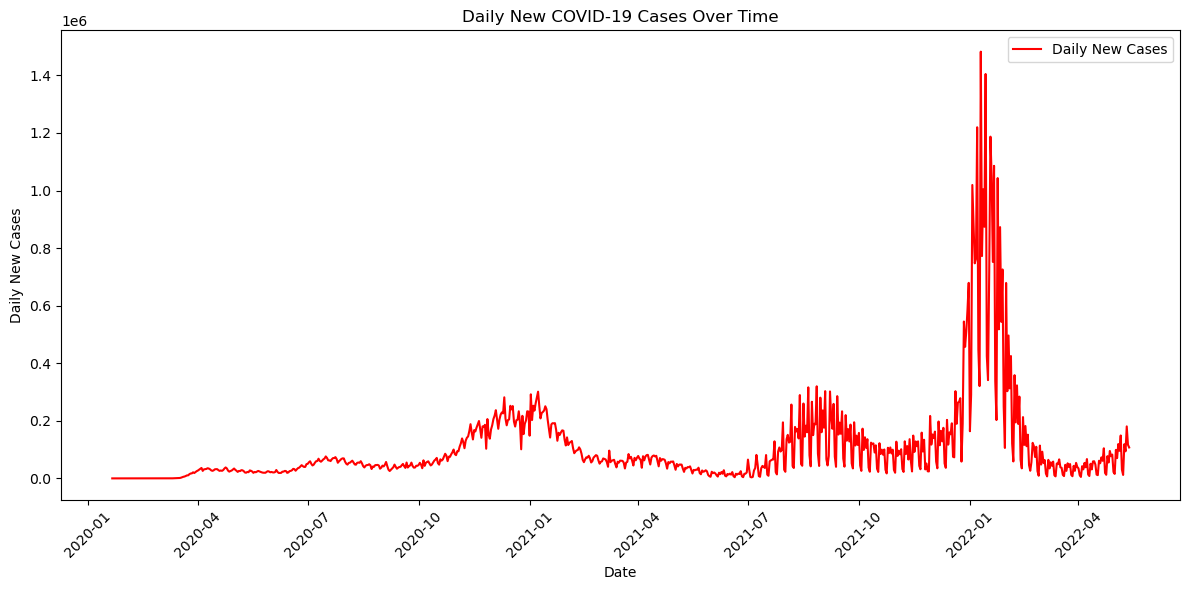

In [4]:
import matplotlib.pyplot as plt

# Assuming the data is already loaded and named as `df`
covid_data['daily_new_cases'] = covid_data.groupby(['county', 'state'])['cases'].diff().fillna(covid_data['cases'])
covid_data['daily_new_cases'] = covid_data['daily_new_cases'].apply(lambda x: x if x >= 0 else 0)

# Summing up daily new cases across all counties and states for each day
daily_new_cases = covid_data.groupby('date')['daily_new_cases'].sum().reset_index()

# Plotting the daily new COVID-19 cases
plt.figure(figsize=(12, 6))
plt.plot(daily_new_cases['date'], daily_new_cases['daily_new_cases'], label='Daily New Cases', color='red')
plt.title('Daily New COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Daily New Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import numpy as np

# Convert 'date' to datetime object
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Find the end of week date (Friday) for each entry
covid_data['end_of_week'] = covid_data['date'] + pd.to_timedelta(
    (4 - covid_data['date'].dt.weekday) % 7, unit='d')

# Now group by 'end_of_week' and 'fips' and sum the 'daily_new_cases'
weekly_cases = covid_data.groupby(['fips','state', 'end_of_week'])['daily_new_cases'].sum().reset_index()

# This DataFrame 'weekly_cases' now has weekly summed cases for each FIPS code.
weekly_cases.head(20)

,fips,state,end_of_week,daily_new_cases
0,1001.0,Alabama,2020-03-27,6.0
1,1001.0,Alabama,2020-04-03,6.0
2,1001.0,Alabama,2020-04-10,5.0
3,1001.0,Alabama,2020-04-17,9.0
4,1001.0,Alabama,2020-04-24,11.0
5,1001.0,Alabama,2020-05-01,7.0
6,1001.0,Alabama,2020-05-08,25.0
7,1001.0,Alabama,2020-05-15,37.0
8,1001.0,Alabama,2020-05-22,46.0
9,1001.0,Alabama,2020-05-29,63.0


In [6]:
# Assuming 'weekly_cases' DataFrame has 'fips' and 'end_of_week' columns from earlier steps
fips_weeks = pd.merge(weekly_cases[["fips", "state"]].drop_duplicates(), weekly_cases[["end_of_week"]].drop_duplicates(), how="cross")
fips_weeks.columns = ["FIPS", "state", "Week"]
fips_weeks.info()
fips_weeks.head(-20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389620 entries, 0 to 389619
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   FIPS    389620 non-null  float64       
 1   state   389620 non-null  object        
 2   Week    389620 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


,FIPS,state,Week
0,1001.0,Alabama,2020-03-27
1,1001.0,Alabama,2020-04-03
2,1001.0,Alabama,2020-04-10
3,1001.0,Alabama,2020-04-17
4,1001.0,Alabama,2020-04-24
...,...,...,...
389595,78030.0,Virgin Islands,2022-01-28
389596,78030.0,Virgin Islands,2022-02-04
389597,78030.0,Virgin Islands,2022-02-11
389598,78030.0,Virgin Islands,2022-02-18


In [7]:
# Merge the `weekly_cases` data with `fips_weeks` to associate the number of new cases with each FIPS code and week.
complete_data = pd.merge(fips_weeks, weekly_cases, how='left', left_on=['FIPS', 'state', 'Week'], right_on=['fips', 'state', 'end_of_week'])
complete_data = complete_data[['FIPS', 'state', 'Week', 'daily_new_cases']]
# Fill any NaN values that result from weeks where a FIPS code had no reported cases with zeros.
complete_data['daily_new_cases'] = complete_data['daily_new_cases'].fillna(0)

# You now have a complete dataset to use as input for your Bayesian network.
# Each row represents a node, with columns for the FIPS code, the week, and the number of new cases.

complete_data.head(-20)

,FIPS,state,Week,daily_new_cases
0,1001.0,Alabama,2020-03-27,6.0
1,1001.0,Alabama,2020-04-03,6.0
2,1001.0,Alabama,2020-04-10,5.0
3,1001.0,Alabama,2020-04-17,9.0
4,1001.0,Alabama,2020-04-24,11.0
...,...,...,...,...
389595,78030.0,Virgin Islands,2022-01-28,262.0
389596,78030.0,Virgin Islands,2022-02-04,56.0
389597,78030.0,Virgin Islands,2022-02-11,73.0
389598,78030.0,Virgin Islands,2022-02-18,18.0


In [8]:
import geopandas as gpd

# Assuming this path is correct and points to your shapefile.
shapefile_path = 'UScounties.shp'
counties = gpd.read_file(shapefile_path)
counties["FIPS"] = counties["FIPS"].astype(float)
counties.info()
counties.head(-20)
weekly_cases= None


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        3141 non-null   object  
 1   STATE_NAME  3141 non-null   object  
 2   STATE_FIPS  3141 non-null   object  
 3   CNTY_FIPS   3141 non-null   object  
 4   FIPS        3141 non-null   float64 
 5   geometry    3141 non-null   geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 147.4+ KB


In [9]:
def get_neighbors(fips_code):
    # Ensure the FIPS code is a string if the DataFrame expects it as such
    fips_float = float(fips_code)
    
    # Select the county based on FIPS code
    county = counties[counties['FIPS'] == fips_float]

    # If the county doesn't exist in the DataFrame, return an empty list
    if county.empty:
        
        return []
    
    # Use spatial joins to find neighbors
    neighbors = gpd.sjoin(counties, county, predicate='touches', how='inner')
    # Get the FIPS codes of the neighbors. Depending on your GeoDataFrame, this could be 'FIPS_left' or just 'FIPS'
    neighbor_fips = neighbors['FIPS_left'].tolist()

    # Return a list of neighbors' FIPS codes, excluding the original county's FIPS code
    return [f for f in neighbor_fips if f != fips_float]


In [10]:
get_neighbors(27057.0)

[27007.0, 27029.0, 27021.0, 27005.0, 27159.0]

In [37]:
# Get a sorted list of unique weeks
sampledata= complete_data[complete_data["state"] == "Illinois"]

# def get_potential_edges(data):
#     potential_edges= []
#     unique_weeks = sorted(data['Week'].unique())
#     for i in range(len(unique_weeks) - 1):
#         week = unique_weeks[i]
#         next_week = unique_weeks[i + 1]
#         current_week_fips = data[data['Week'] == week]['FIPS'].unique()
#         next_week_fips = data[data['Week'] == next_week]['FIPS'].unique()

#         for fips in current_week_fips:
#             neighbors = get_neighbors(fips)
#             for neighbor in neighbors:
#                 # Check if each neighbor also has a record in the next week
#                 if neighbor in next_week_fips:
#                     # Append the tuple (current_week_fips, next_week_fips) to the potential edges
#                     source = var_to_str((fips, week))
#                     target = var_to_str((neighbor, next_week))
#                     potential_edges.append((source, target))
#     return potential_edges


def get_potential_edges(data):
    """data comes in with columns ['FIPS', 'state', 'Week', 'daily_new_cases']"""
    potential_edges= []
    fip_list = data["FIPS"].unique()
    for fips in fip_list:
        neighbors = get_neighbors(fips)
        for neighbor in neighbors:
            # Append the tuple (current_week_fips, next_week_fips) to the potential edges
            # Needs to match how `convert_data` names the columns
            source = str(fips) + "_current"
            target = str(neighbor) + "_next"
            potential_edges.append((source, target))
    return potential_edges



In [38]:
potential_edges = get_potential_edges(sampledata)
print(potential_edges)
print(len(potential_edges))

[('17001.0_current', '17067.0_next'), ('17001.0_current', '17169.0_next'), ('17001.0_current', '29111.0_next'), ('17001.0_current', '17009.0_next'), ('17001.0_current', '29127.0_next'), ('17001.0_current', '17149.0_next'), ('17003.0_current', '17181.0_next'), ('17003.0_current', '29031.0_next'), ('17003.0_current', '17153.0_next'), ('17003.0_current', '29201.0_next'), ('17003.0_current', '21007.0_next'), ('17003.0_current', '29133.0_next'), ('17005.0_current', '17135.0_next'), ('17005.0_current', '17051.0_next'), ('17005.0_current', '17119.0_next'), ('17005.0_current', '17027.0_next'), ('17007.0_current', '55105.0_next'), ('17007.0_current', '55127.0_next'), ('17007.0_current', '17201.0_next'), ('17007.0_current', '17111.0_next'), ('17007.0_current', '17141.0_next'), ('17007.0_current', '17037.0_next'), ('17009.0_current', '17169.0_next'), ('17009.0_current', '17001.0_next'), ('17009.0_current', '17017.0_next'), ('17009.0_current', '17137.0_next'), ('17009.0_current', '17149.0_next'), 

In [45]:
def convert_data(data):
    """
    Converts data looking like `complete_data` into
    a dataframe that has columns
    - FIPS
    - state
    - current_week_cases
    - next_week_cases
    """
    # First shift the data to separate this week from next
    # Step 1: Sort the DataFrame
    data = data.sort_values(by=["FIPS", "state", "Week"])

    # Step 2: Shift the cases column to create next_week_cases
    data['next_week_cases'] = data.groupby(['FIPS', 'state'])['daily_new_cases'].shift(-1)

    # Step 3: Rename the original cases column and create the final DataFrame
    data.rename(columns={'daily_new_cases': 'current_week_cases'}, inplace=True)
    data = data[['FIPS', 'state', 'Week', 'current_week_cases', 'next_week_cases']]

    # Next convert the dataframe into a format for pgmpy
    # Step 1: Create new DataFrame for pgmpy input
    # We need to make two entries per row: one for _current and one for _next
    data_current = data[['FIPS', 'Week', 'current_week_cases']].copy()
    data_next = data[['FIPS', 'Week', 'next_week_cases']].copy()

    # Rename columns
    data_current.columns = ['FIPS', 'Week', 'cases']
    data_next.columns = ['FIPS', 'Week', 'cases']

    # Add a suffix to distinguish between current and next
    data_current['variable'] = data_current['FIPS'].astype(str) + '_current'
    data_next['variable'] = data_next['FIPS'].astype(str) + '_next'

    # Concatenate both DataFrames vertically
    pgmpy_data = pd.concat([data_current, data_next], ignore_index=True)

    # Pivot to wide format
    pgmpy_data = pgmpy_data.pivot_table(index='Week', columns='variable', values='cases', aggfunc='first')

    # Flatten the columns MultiIndex (not needed here, just simplifying)
    pgmpy_data.columns = pgmpy_data.columns.get_level_values(0)

    return pgmpy_data
    


def discretize_all_columns(data, num_quantiles=5):
    """`data` should be in form output by `convert_data`"""
    # Dictionary to store bin edges
    bin_edges_dict = {}

    # Function to calculate quantile-based bins and apply discretization
    def discretize_columns(df, fip):
        current_col = f"{fip}_current"
        next_col = f"{fip}_next"
        # Combine current and next week cases to get full range of data for binning
        combined_series = pd.concat([df[current_col], df[next_col]]).dropna()
        # Calculate the quantile edges
        quantiles = np.linspace(0, 1, num_quantiles + 1)
        bin_edges = combined_series.quantile(quantiles)
        # Ensure uniqueness and sort them
        unique_edges = sorted(set(bin_edges))
        # Store bin edges in dictionary
        bin_edges_dict[current_col] = unique_edges
        bin_edges_dict[next_col] = unique_edges
        # Discretize both columns using the same bin edges
        labels = [f"bin_{i+1}" for i in range(len(unique_edges)-1)]
        df[current_col] = pd.cut(df[current_col], bins=unique_edges, labels=labels, include_lowest=True)
        df[next_col] = pd.cut(df[next_col], bins=unique_edges, labels=labels, include_lowest=True)

    # Apply the discretization function to each FIP group
    fips = set(col.split('_')[0] for col in data.columns)
    for fip in fips:
        discretize_columns(data, fip)

    # Create a DataFrame from the bin edges dictionary
    bin_edges_df = pd.DataFrame.from_dict(bin_edges_dict, orient='index').T

    # The resulting DataFrames
    return data, bin_edges_df

In [57]:
hill_climb_data, bins_df = discretize_all_columns(convert_data(sampledata), num_quantiles=5)
display(hill_climb_data.head(20))
display(bins_df)
hill_climb_data.info()

variable,17001.0_current,17001.0_next,17003.0_current,17003.0_next,17005.0_current,17005.0_next,17007.0_current,17007.0_next,17009.0_current,17009.0_next,...,17195.0_current,17195.0_next,17197.0_current,17197.0_next,17199.0_current,17199.0_next,17201.0_current,17201.0_next,17203.0_current,17203.0_next
Week,,,,,,,,,,,,,,,,,,,,,
2020-01-24,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-01-31,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-02-07,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-02-14,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-02-21,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-02-28,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-03-06,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-03-13,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1
2020-03-20,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,...,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1,bin_1


,17067.0_current,17067.0_next,17093.0_current,17093.0_next,17131.0_current,17131.0_next,17161.0_current,17161.0_next,17203.0_current,17203.0_next,...,17099.0_current,17099.0_next,17183.0_current,17183.0_next,17023.0_current,17023.0_next,17049.0_current,17049.0_next,17143.0_current,17143.0_next
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2.0,55.0,55.0,2.0,2.0,43.0,43.0,8.0,8.0,...,22.0,22.0,9.0,9.0,3.0,3.0,4.0,4.0,37.0,37.0
2,10.0,10.0,109.0,109.0,9.0,9.0,130.0,130.0,34.0,34.0,...,100.0,100.0,53.0,53.0,11.0,11.0,16.0,16.0,183.0,183.0
3,26.0,26.0,193.0,193.0,23.0,23.0,214.0,214.0,64.0,64.0,...,161.0,161.0,191.0,191.0,23.0,23.0,64.0,64.0,316.0,316.0
4,68.0,68.0,398.0,398.0,51.0,51.0,403.0,403.0,138.0,138.0,...,313.0,313.0,391.0,391.0,75.0,75.0,148.0,148.0,649.0,649.0
5,228.0,228.0,2483.0,2483.0,274.0,274.0,2195.0,2195.0,716.0,716.0,...,2698.0,2698.0,2300.0,2300.0,360.0,360.0,666.0,666.0,3370.0,3370.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2020-01-24 to 2022-05-13
Columns: 204 entries, 17001.0_current to 17203.0_next
dtypes: category(204)
memory usage: 67.1 KB


In [58]:
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork

def model_train(data,potential_edges): 
        # Define the scoring function using BIC
    bic = BicScore(data)

    # Initialize the Hill Climb Search without specifying the scoring method here
    hcs = HillClimbSearch(data)

    # Run the Hill Climb Search using the potential edges as a whitelist and set the scoring method here
    best_model = hcs.estimate(white_list=potential_edges, scoring_method=bic)
    # print(f"BIC: {bic.score(best_model)}")
    print(best_model)
    # Update the Bayesian Network with the edges from the best model found
    bayesian_network = BayesianNetwork(best_model.edges())

    return bayesian_network


bn = model_train(hill_climb_data, potential_edges)

  0%|          | 0/1000000 [00:00<?, ?it/s]

BIC: -35473.26587564094
DAG with 204 nodes and 102 edges


In [59]:
bn.edges

OutEdgeView([('17001.0_current', '17067.0_next'), ('17001.0_current', '17149.0_next'), ('17003.0_current', '17153.0_next'), ('17007.0_current', '17201.0_next'), ('17011.0_current', '17175.0_next'), ('17011.0_current', '17155.0_next'), ('17019.0_current', '17113.0_next'), ('17029.0_current', '17035.0_next'), ('17029.0_current', '17041.0_next'), ('17029.0_current', '17023.0_next'), ('17031.0_current', '17097.0_next'), ('17037.0_current', '17111.0_next'), ('17037.0_current', '17099.0_next'), ('17037.0_current', '17103.0_next'), ('17039.0_current', '17147.0_next'), ('17043.0_current', '17197.0_next'), ('17043.0_current', '17089.0_next'), ('17043.0_current', '17031.0_next'), ('17047.0_current', '17193.0_next'), ('17047.0_current', '17185.0_next'), ('17049.0_current', '17173.0_next'), ('17049.0_current', '17051.0_next'), ('17049.0_current', '17079.0_next'), ('17053.0_current', '17183.0_next'), ('17055.0_current', '17199.0_next'), ('17055.0_current', '17065.0_next'), ('17057.0_current', '1710